# **Team Member**


*   Chenhao Zhu
*   Zimu Xu

link : https://colab.research.google.com/drive/1T8g0sG_uivWggdZXOw6PSod6SvFurVkn?usp=sharing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/APS1052/Multi_Asset/functions.py /content/functions.py

Mounted at /content/drive


In [ ]:
! pwd

/content


In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random


print('Done')

Done


# **Importing Data**

In [ ]:
path = '/content/drive/MyDrive/APS1052/Project/'
tn = 'TSLA_day.csv'


# tsla = pd.read_csv(path + tn)
# tsla['Date'] = pd.to_datetime(tsla.Date,format='%Y-%m-%d')
# # tsla.rename({'Adj Close' : 'Close'}, axis = 1, inplace = True)
# tsla.index = tsla.Date
# tsla

path = '/content/drive/MyDrive/APS1052/Multi_Asset/data/'

tn1 = 'TSLA.csv'
tn2 = 'ABRV.csv'
tn3 = 'AMZN.csv'
tn4 = 'MSFT.csv'
tn5 = 'NVDA.csv'
tn6 = 'KIPV.csv'


tsla = pd.read_csv(path + tn1)
abrv = pd.read_csv(path + tn2)
amzn = pd.read_csv(path + tn3)
msft = pd.read_csv(path + tn4)
nvda = pd.read_csv(path + tn5)
kipv = pd.read_csv(path + tn6)

tsla['Date'] = pd.to_datetime(tsla.Date,format='%Y-%m-%d')
abrv['Date'] = pd.to_datetime(abrv.Date,format='%Y-%m-%d')
amzn['Date'] = pd.to_datetime(amzn.Date,format='%Y-%m-%d')
msft['Date'] = pd.to_datetime(msft.Date,format='%Y-%m-%d')
nvda['Date'] = pd.to_datetime(nvda.Date,format='%Y-%m-%d')
kipv['Date'] = pd.to_datetime(kipv.Date,format='%Y-%m-%d')

# tsla.rename({'Adj Close' : 'Close'}, axis = 1, inplace = True)
# tsla.index = tsla.Date
df0 = pd.DataFrame({'TSLA' : tsla.Close,
                #    'ABRV' : abrv.Close,
                   'AMZN' : amzn.Close,
                   'MSFT' : nvda.Close,
                   'NVDA' : msft.Close})
                #    'KIPV' : kipv.Close})
# tsla['Company'] = 'TSLA'

df = df0.fillna(0)
df2 = df0.dropna()
df

,TSLA,AMZN,MSFT,NVDA
0,16.661333,29.796499,8.970000,54.310001
1,16.521334,30.158501,8.960000,54.650002
2,16.968666,30.740999,9.185000,55.349998
3,16.790667,31.037500,9.210000,55.360001
4,16.967333,31.294500,9.282500,55.650002
...,...,...,...,...
1758,192.580002,103.949997,274.529999,287.179993
1759,185.520004,101.099998,268.809998,284.339996
1760,185.059998,102.059998,270.369995,291.600006
1761,184.509995,102.169998,275.790009,289.390015


In [ ]:
df2['days'] = df2.index
df = df2.drop(['days'], axis = 1)
df2

,TSLA,AMZN,MSFT,NVDA,days
0,16.661333,29.796499,8.970000,54.310001,0
1,16.521334,30.158501,8.960000,54.650002,1
2,16.968666,30.740999,9.185000,55.349998,2
3,16.790667,31.037500,9.210000,55.360001,3
4,16.967333,31.294500,9.282500,55.650002,4
...,...,...,...,...,...
1758,192.580002,103.949997,274.529999,287.179993,1758
1759,185.520004,101.099998,268.809998,284.339996,1759
1760,185.059998,102.059998,270.369995,291.600006,1760
1761,184.509995,102.169998,275.790009,289.390015,1761


<Axes: xlabel='days', ylabel='number'>

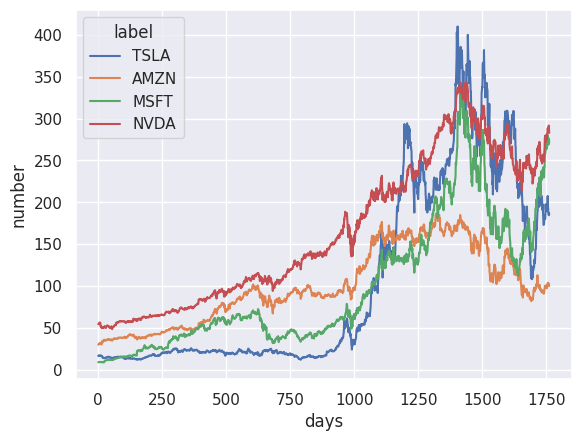

In [ ]:
melted_df = df2.melt('days', var_name='label', value_name='number')
sns.set_theme()
sns.lineplot(melted_df, y = 'number', x = 'days', hue = 'label')#, hue = ['label']



In [ ]:
holdingDays = 252 // 4; #hold a quarter
Ret1 = fn.calculateReturns(df.copy(), 1)
RetQ = fn.calculateReturns(df.copy(), holdingDays)
Ret1.shape, RetQ.shape

((1763, 4), (1763, 4))

In [ ]:
RetFut = RetQ.copy().shift(-(holdingDays+1))
#############################
m = Ret1.shape[0]
trainSize = (m // 3) * 2
testSize = m - trainSize
#############################

#Ret1train = Ret1[:trainSize]
#Ret1test = Ret1[trainSize:]

Ret1train = df[:trainSize].fillna(value=0)
Ret1test = df[trainSize:].fillna(value=0)

m, trainSize, testSize

(1763, 1174, 589)

# **Prepareing Data**

In [ ]:
import math
from numpy import array

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def getTrain(data, n_step, K) :
    df0 = data[[K]]
    # train_index, val_index = math.floor(df0.shape[0] * 0.6), math.floor(df0.shape[0] * 0.8)
    train = data[K].values#df0.iloc[: val_index][K].values
    # valid = df0.iloc[train_index : val_index].Close.values
    # test = df0.iloc[val_index :][K].values
    # Define step
    # n_step = 10
    X_train, y_train = split_sequence(train, n_step)
    # X_test, y_test = split_sequence(test, n_step)
    return X_train, y_train#, X_test, y_test, train_index, val_index

X_train1, y_train1= getTrain(Ret1train[['TSLA']], 30, 'TSLA')#, X_test1, y_test1, train_index1, val_index1 
# X_train2, y_train2= getTrain(Ret1train[['ABRV']], 15, 'ABRV')#, X_test2, y_test2, train_index2, val_index2 
X_train3, y_train3= getTrain(Ret1train[['AMZN']], 30, 'AMZN')#, X_test3, y_test3, train_index3, val_index3 
X_train4, y_train4= getTrain(Ret1train[['MSFT']], 30, 'MSFT')#, X_test4, y_test4, train_index4, val_index4 
X_train5, y_train5= getTrain(Ret1train[['NVDA']], 30, 'NVDA')#, X_test5, y_test5, train_index5, val_index5 
# X_train6, y_train6= getTrain(Ret1train[['KIPV']], 15, 'KIPV')#, X_test6, y_test6, train_index6, val_index6 


X_train = np.concatenate([X_train1, X_train3, X_train4, X_train5], axis=0)
y_train = np.concatenate([y_train1, y_train3, y_train4, y_train5], axis=0)
# X_test = np.concatenate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], axis=0)
# y_test = np.concatenate([y_test1, y_test2, y_test3, y_test4, y_test5, y_test6], axis=0)

In [ ]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)

minY = y_train.min()
maxY = y_train.max()
y_train2 = (y_train - minY) / (maxY - minY)

pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.035752,0.035124,0.037131,0.036332,0.037125,0.036936,0.034990,0.035767,0.035265,0.036898,...,0.022923,0.022536,0.022617,0.022114,0.016240,0.015099,0.013904,0.014664,0.015672,0.016334
1,0.035124,0.037131,0.036332,0.037125,0.036936,0.034990,0.035767,0.035265,0.036898,0.036320,...,0.022854,0.022617,0.022114,0.022213,0.016445,0.014005,0.015868,0.015884,0.017203,0.015107
2,0.037131,0.036332,0.037125,0.036936,0.034990,0.035767,0.035265,0.036898,0.036320,0.036895,...,0.022935,0.022114,0.022213,0.022417,0.015352,0.015968,0.017086,0.017415,0.015977,0.015618
3,0.036332,0.037125,0.036936,0.034990,0.035767,0.035265,0.036898,0.036320,0.036895,0.036216,...,0.022433,0.022213,0.022417,0.021330,0.017312,0.017186,0.018615,0.016189,0.016488,0.016123
4,0.037125,0.036936,0.034990,0.035767,0.035265,0.036898,0.036320,0.036895,0.036216,0.035091,...,0.022531,0.022417,0.021330,0.023279,0.018529,0.018715,0.017390,0.016699,0.016992,0.017797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,0.946224,0.921825,0.923753,0.924426,0.924830,0.930840,0.903256,0.917474,0.870066,0.879216,...,0.932056,0.935266,0.922831,0.907657,0.913146,0.903846,0.902569,0.919433,0.919461,0.925556
4572,0.921825,0.923753,0.924426,0.924830,0.930840,0.903256,0.917474,0.870066,0.879216,0.869125,...,0.935287,0.922831,0.907657,0.913673,0.903977,0.902579,0.919531,0.919478,0.925621,0.920297
4573,0.923753,0.924426,0.924830,0.930840,0.903256,0.917474,0.870066,0.879216,0.869125,0.868497,...,0.922856,0.907657,0.913673,0.904560,0.902712,0.919540,0.919577,0.925637,0.920367,0.929999
4574,0.924426,0.924830,0.930840,0.903256,0.917474,0.870066,0.879216,0.869125,0.868497,0.886886,...,0.907688,0.913673,0.904560,0.903303,0.919650,0.919585,0.925728,0.920384,0.930061,0.926190


In [ ]:
# X_train
print(X_train.shape, y_train.shape)
x_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(4576, 30) (4576,)
(4576, 30, 1) (4576,)


In [ ]:
X_test1, y_test1= getTrain(Ret1test[['TSLA']], 30, 'TSLA')#, X_test1, y_test1, train_index1, val_index1 
# X_test2, y_test2= getTrain(Ret1test[['ABRV']], 15, 'ABRV')#, X_test2, y_test2, train_index2, val_index2 
X_test3, y_test3= getTrain(Ret1test[['AMZN']], 30, 'AMZN')#, X_test3, y_test3, train_index3, val_index3 
X_test4, y_test4= getTrain(Ret1test[['MSFT']], 30, 'MSFT')#, X_test4, y_test4, train_index4, val_index4 
X_test5, y_test5= getTrain(Ret1test[['NVDA']], 30, 'NVDA')#, X_test5, y_test5, train_index5, val_index5 
# X_test6, y_test6= getTrain(Ret1test[['KIPV']], 15, 'KIPV')#, X_test6, y_test6, train_index6, val_index6 


X_test = np.concatenate([X_test1, X_test3, X_test4, X_test5], axis=0)
y_test = np.concatenate([y_test1, y_test3, y_test4, y_test5], axis=0)

X_test = scaler.transform(X_test)
y_test2 = (y_test - minY) / (maxY - minY)

pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.920479,0.932619,0.864744,0.898517,0.872982,0.917594,0.907756,0.892088,0.941619,1.000075,...,1.091295,1.181199,1.276938,1.173941,1.232590,1.240401,1.226238,1.198074,1.225884,1.235000
1,0.932619,0.864744,0.898517,0.872982,0.917594,0.907756,0.892088,0.941619,1.000075,0.932589,...,1.181140,1.276938,1.173941,1.231178,1.240073,1.226215,1.197832,1.225835,1.234792,1.226748
2,0.864744,0.898517,0.872982,0.917594,0.907756,0.892088,0.941619,1.000075,0.932589,0.918356,...,1.276848,1.173941,1.231178,1.238615,1.225906,1.197812,1.225559,1.234742,1.226548,1.229242
3,0.898517,0.872982,0.917594,0.907756,0.892088,0.941619,1.000075,0.932589,0.918356,0.926788,...,1.173884,1.231178,1.238615,1.224534,1.197541,1.225536,1.234455,1.226499,1.229039,1.280866
4,0.872982,0.917594,0.907756,0.892088,0.941619,1.000075,0.932589,0.918356,0.926788,0.950395,...,1.231103,1.238615,1.224534,1.196342,1.225228,1.234431,1.226223,1.228990,1.280618,1.284327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,1.094277,1.089074,1.103696,1.078803,1.083019,1.079700,1.065572,1.087280,1.106028,1.113114,...,1.189068,1.182441,1.206548,1.219611,1.202028,1.197103,1.221006,1.237308,1.256611,1.251986
2232,1.089074,1.103696,1.078803,1.083019,1.079700,1.065572,1.087280,1.106028,1.113114,1.100915,...,1.182381,1.206548,1.219611,1.200801,1.196834,1.220984,1.237018,1.256555,1.251764,1.251760
2233,1.103696,1.078803,1.083019,1.079700,1.065572,1.087280,1.106028,1.113114,1.100915,1.098897,...,1.206480,1.219611,1.200801,1.195639,1.220682,1.236994,1.256242,1.251710,1.251537,1.238884
2234,1.078803,1.083019,1.079700,1.065572,1.087280,1.106028,1.113114,1.100915,1.098897,1.092707,...,1.219540,1.200801,1.195639,1.219342,1.236670,1.256216,1.251402,1.251483,1.238673,1.271799


In [ ]:
# X_train
print(X_test.shape, y_test.shape)
x_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(x_test.shape, y_test.shape)

(2236, 30) (2236,)
(2236, 30, 1) (2236,)


# **Modeling**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res




def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr


callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

input_shape = x_train.shape[1:]
print(input_shape)


model = build_model(
    input_shape,
    head_size=9, # Embedding size for attention
    num_heads=10, # Number of attention heads
    ff_dim=64, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.2,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train2,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

(30, 1)
Epoch 1/50
115/115 [==============================] - 25s 113ms/step - loss: 0.1902 - mean_squared_error: 0.1902 - val_loss: 0.7413 - val_mean_squared_error: 0.7413 - lr: 1.0000e-06
Epoch 2/50
115/115 [==============================] - 12s 107ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - lr: 3.4300e-05
Epoch 3/50
115/115 [==============================] - 13s 113ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 6.6931e-04 - val_mean_squared_error: 6.6931e-04 - lr: 6.7600e-05
Epoch 4/50
115/115 [==============================] - 14s 118ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 6.8075e-04 - val_mean_squared_error: 6.8075e-04 - lr: 1.0090e-04
Epoch 5/50
115/115 [==============================] - 14s 119ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 1.3420e-04
Epoch 6/50
115/115 [==============================] - 14s 119ms/st

In [ ]:
val_loss = history.history['val_loss']
val_mean_squared_error = history.history['val_mean_squared_error']

train_loss = history.history['loss']
train_mean_squared_error = history.history['mean_squared_error']

model_info = pd.DataFrame(
    {'Epoch' : list(range(1, len(val_loss)+1)),
     'Train_Loss' : train_loss,
     'Train_MSE' : train_mean_squared_error,
     'Valid_Loss' : val_loss,
     'Valid_MSE' : val_mean_squared_error}
)
# model_info
print(train_loss[:5])
print(train_mean_squared_error[:5])
print(val_loss[:5])
print(val_mean_squared_error[:5])

[0.19022056460380554, 0.061280883848667145, 0.012554844841361046, 0.009948375634849072, 0.007858571596443653]
[0.19022056460380554, 0.061280883848667145, 0.012554844841361046, 0.009948375634849072, 0.007858571596443653]
[0.7412720322608948, 0.034554414451122284, 0.0006693050381727517, 0.0006807472673244774, 0.001990529242902994]
[0.7412720322608948, 0.034554414451122284, 0.0006693050381727517, 0.0006807472673244774, 0.001990529242902994]


[]

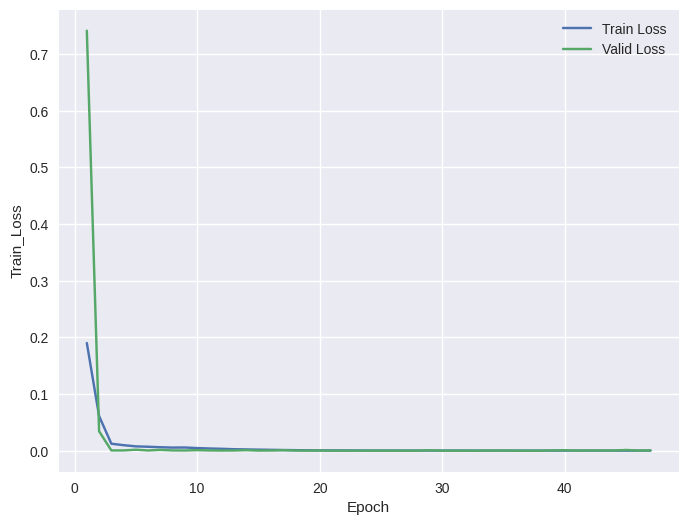

In [ ]:
plt.figure(figsize = (8, 6))
# plt.title('Train Loss Vs Validate Loss')
sns.lineplot(model_info, y = 'Train_Loss', x = 'Epoch', label = 'Train Loss')
sns.lineplot(model_info, y = 'Valid_Loss', x = 'Epoch', label = 'Valid Loss')
plt.legend()
plt.plot()

In [ ]:
path2 = '/content/drive/MyDrive/APS1052/Multi_Asset/model/'

modelname = 'Transformer_price_step30_v1.h5'

# model.save_weights(path2 + modelname)  # to store
model = setupModel(n_step = 30)
model.load_weights(path2 + modelname)  # to load

# **Testing and Visualization**

In [ ]:
# predicted_stock_price = model.predict(X_test)
# yhat = model.predict(X_train, verbose=0)
# yhat = yhat * (maxY - minY) + minY



**Training Cumulative Return**

In [ ]:
yhat = model.predict(X_train, verbose=0)
yhat = yhat * (maxY - minY) + minY

rt = pd.DataFrame({'Pred' : yhat.T[0]})
rt = rt.to_numpy().reshape(4, int(rt.shape[0]/4)).T
rt = pd.DataFrame(rt, columns=df.columns.tolist())
rt['days'] = rt.index

rt_2 = rt.melt('days', var_name='label', value_name='number')
rt = rt.drop(['days'], axis = 1)



rt2 = pd.DataFrame({'Actual' : y_train})
rt2 = rt2.to_numpy().reshape(4, int(rt2.shape[0]/4)).T
rt2 = pd.DataFrame(rt2, columns=df.columns.tolist())
rt2['days'] = rt2.index

rt2_2 = rt2.melt('days', var_name='label', value_name='number')
rt2 = rt2.drop(['days'], axis = 1)

yhat.shape

(4576, 1)

[]

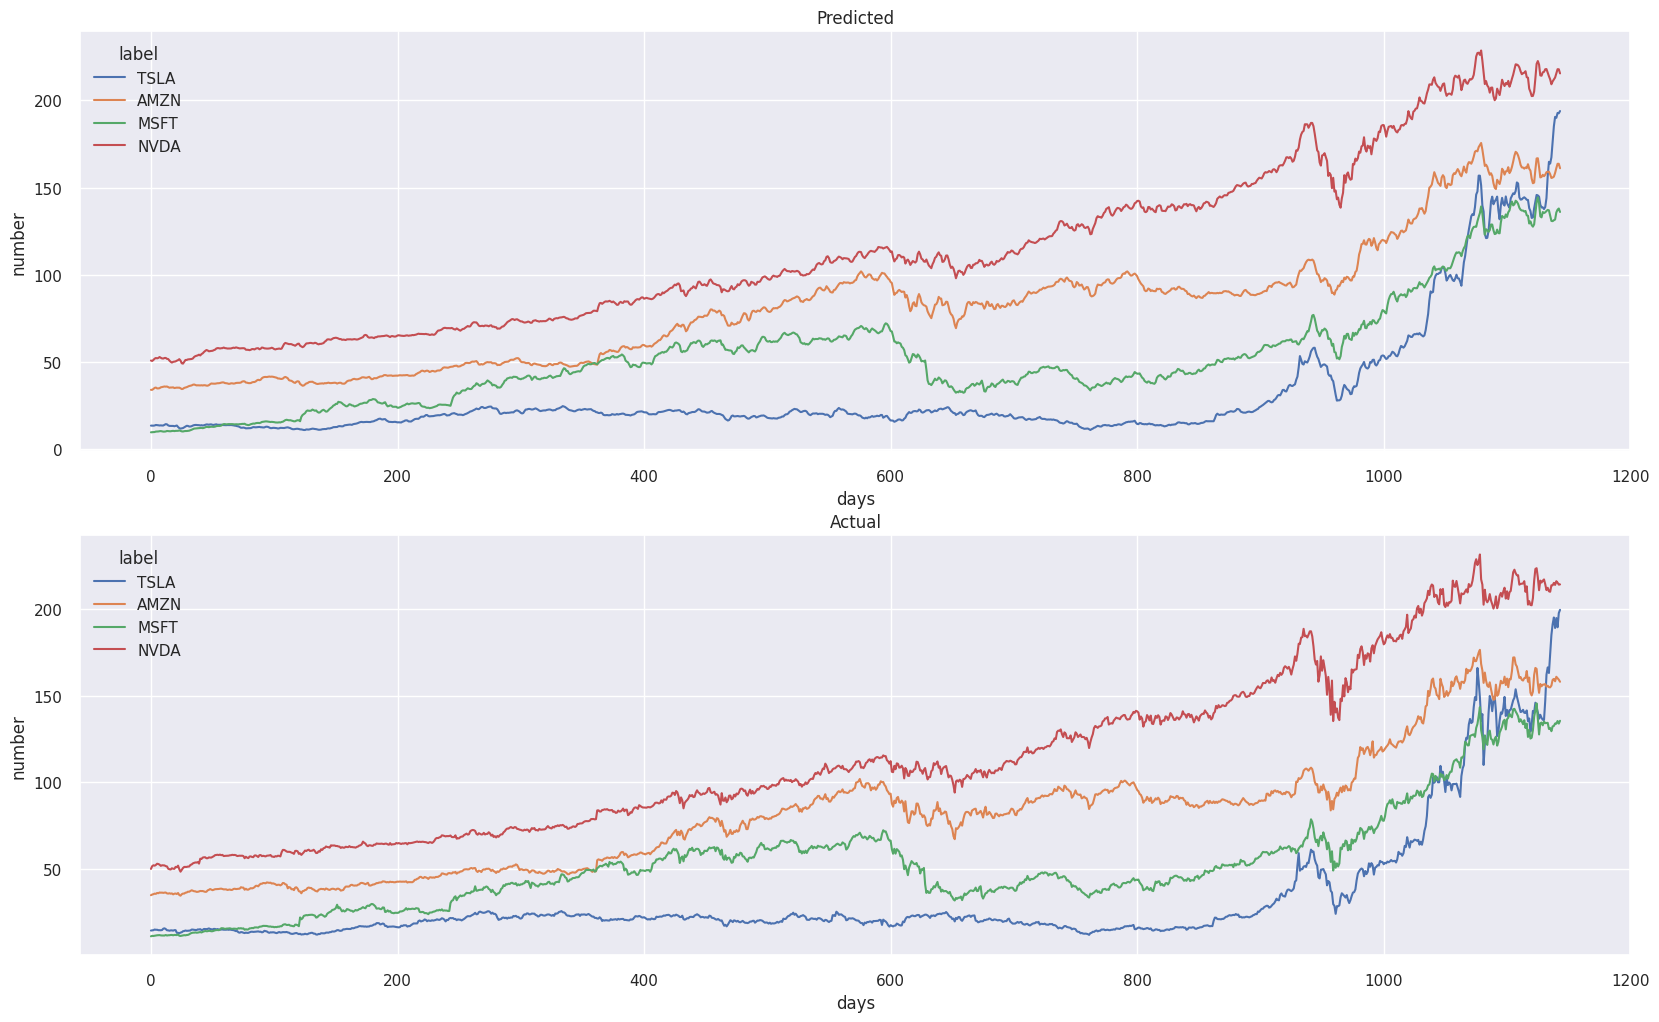

In [ ]:
fig = plt.figure(figsize = (20, 12))
ax1 = fig.add_subplot(211)
sns.set_theme()

ax1.set_title('Predicted')
sns.lineplot(rt_2, y = 'number', x = 'days', hue = 'label')#, hue = ['label']

ax2 = fig.add_subplot(212)
ax2.set_title('Actual')
sns.lineplot(rt2_2, y = 'number', x = 'days', hue = 'label')
plt.plot()

In [ ]:
# pred2 = pd.DataFrame(yhat.T[0])
retPred_test = fn.calculateReturns(rt.copy(), 1).fillna(0)
# retPred_test = pred2.to_numpy().reshape(int(pred2.shape[0]/4), 4)
retPred_test = pd.DataFrame(retPred_test)
retPred_test

,TSLA,AMZN,MSFT,NVDA
0,0.000000,0.000000,0.000000,0.000000
1,-0.001366,-0.000163,0.007456,-0.004822
2,-0.000582,0.014854,0.007787,0.011408
3,0.008077,0.017627,0.001752,0.014286
4,0.020919,0.005513,0.023663,0.007384
...,...,...,...,...
1139,0.029223,0.013607,0.002998,0.005117
1140,-0.002817,0.017545,0.030939,0.011703
1141,0.014752,0.015285,0.011510,0.010607
1142,-0.000991,0.000021,0.004927,-0.000221


In [ ]:
retPred_test2 = fn.calculateReturns(Ret1train.copy(), 1).fillna(0)
retPred_test2 = retPred_test2.iloc[30:].reset_index(drop = True)
retPred_test2.loc[0, :] = 0
retPred_test2

,TSLA,AMZN,MSFT,NVDA
0,0.000000,0.000000,0.000000,0.000000
1,0.007816,0.010692,0.021622,0.031181
2,0.007664,0.005893,-0.004189,0.010273
3,0.025230,0.009261,0.010627,-0.004413
4,-0.009240,-0.003735,0.005476,0.008287
...,...,...,...,...
1139,-0.031002,-0.008544,0.010576,-0.005390
1140,0.030233,0.016427,-0.000858,0.009997
1141,-0.027259,-0.005140,0.011539,-0.003885
1142,0.043177,-0.005244,-0.010964,-0.005247


In [ ]:
longs = pd.DataFrame((retPred_test>0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame((retPred_test<0).astype(int)).shift(1)
longs.loc[0] = 0
shorts.loc[0] = 0

# retPred_test.shape, longs.shape, shorts.shape

positions = np.zeros(retPred_test.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.astype(bool).values
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.astype(bool).values
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).values.squeeze(), 
                           retPred_test.fillna(0).values), axis = 1)
               

dPos = np.sum(pd.DataFrame(positions).shift(1).abs().values.squeeze(), axis = 1)

# dRetA.shape, dPos.shape

dailyRet = np.divide(dRetA, dPos)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

dailyRet.shape, cumret.shape

((1144,), (1144,))

In [ ]:
longs2 = pd.DataFrame((retPred_test2>0).astype(int)).shift(1) #1 day later
shorts2 = pd.DataFrame((retPred_test2<0).astype(int)).shift(1)
longs2.loc[0] = 0
shorts2.loc[0] = 0

# retPred_test.shape, longs.shape, shorts.shape

positions2 = np.zeros(retPred_test2.shape)

for h in range(holdingDays):
    long_lag2 = longs2.shift(h)
    long_lag2.fillna(value=0, inplace=True)
    long_lag2 = long_lag2.astype(bool).values
    
    short_lag2 = shorts2.shift(h)
    short_lag2.fillna(value=0, inplace=True)
    short_lag2 = short_lag2.astype(bool).values
    
    positions2[long_lag2] += 1
    positions2[short_lag2] -= 1

dRetA2 = np.sum(np.multiply(pd.DataFrame(positions2).shift(1).fillna(0).values.squeeze(), 
                           retPred_test2.fillna(0).values), axis = 1)
               

dPos2 = np.sum(pd.DataFrame(positions2).shift(1).abs().values.squeeze(), axis = 1)

# dRetA.shape, dPos.shape

dailyRet2 = np.divide(dRetA2, dPos2)
dailyRet2[~np.isfinite(dailyRet2)] = 0
cumret2 = np.cumprod(1 + dailyRet2) - 1

dailyRet2.shape, cumret2.shape

((1144,), (1144,))

in-sample: CAGR=0.779127 Sharpe ratio=1.54126 maxDD=-0.369624 maxDDD=464 Calmar ratio=2.10789


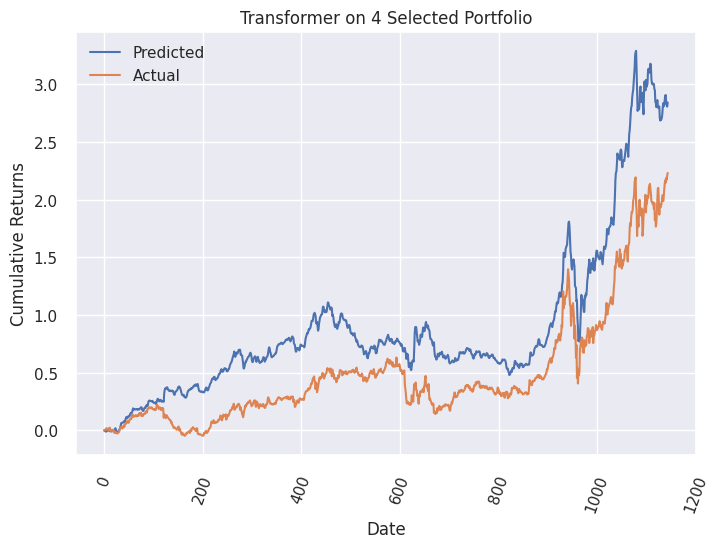

In [ ]:
plt.figure(2)
plt.xticks(rotation=70)
plt.plot(retPred_test.index, cumret, label = 'Predicted')
plt.plot(retPred_test2.index, cumret2, label = 'Actual')
plt.title('Transformer on 4 Selected Portfolio')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('in-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show()

**Testing Cumulative Return**

In [ ]:
yhat = model.predict(X_test, verbose=0)
yhat = yhat * (maxY - minY) + minY

rt = pd.DataFrame({'Pred' : yhat.T[0]})
rt = rt.to_numpy().reshape(4, int(rt.shape[0]/4)).T
rt = pd.DataFrame(rt, columns=df.columns.tolist())
rt['days'] = rt.index

rt_2 = rt.melt('days', var_name='label', value_name='number')
rt = rt.drop(['days'], axis = 1)



rt2 = pd.DataFrame({'Actual' : y_test})
rt2 = rt2.to_numpy().reshape(4, int(rt2.shape[0]/4)).T
rt2 = pd.DataFrame(rt2, columns=df.columns.tolist())
rt2['days'] = rt2.index

rt2_2 = rt2.melt('days', var_name='label', value_name='number')
rt2 = rt2.drop(['days'], axis = 1)

yhat.shape

(2236, 1)

In [ ]:
# rt2_2[rt2_2.label == 'AMZN'].number.describe()
rt

,TSLA,AMZN,MSFT,NVDA
0,275.420563,160.142899,132.646286,220.186249
1,277.806000,163.831711,136.907822,223.701706
2,279.955902,166.050720,138.347366,225.726379
3,279.689331,166.200821,137.561111,227.855820
4,286.400391,167.551575,136.737289,231.228882
...,...,...,...,...
554,199.391693,103.115662,275.213104,282.646240
555,194.062271,103.182518,273.672516,282.592407
556,188.208664,101.866074,266.716705,280.257477
557,189.222717,102.413551,265.971588,285.287170


[]

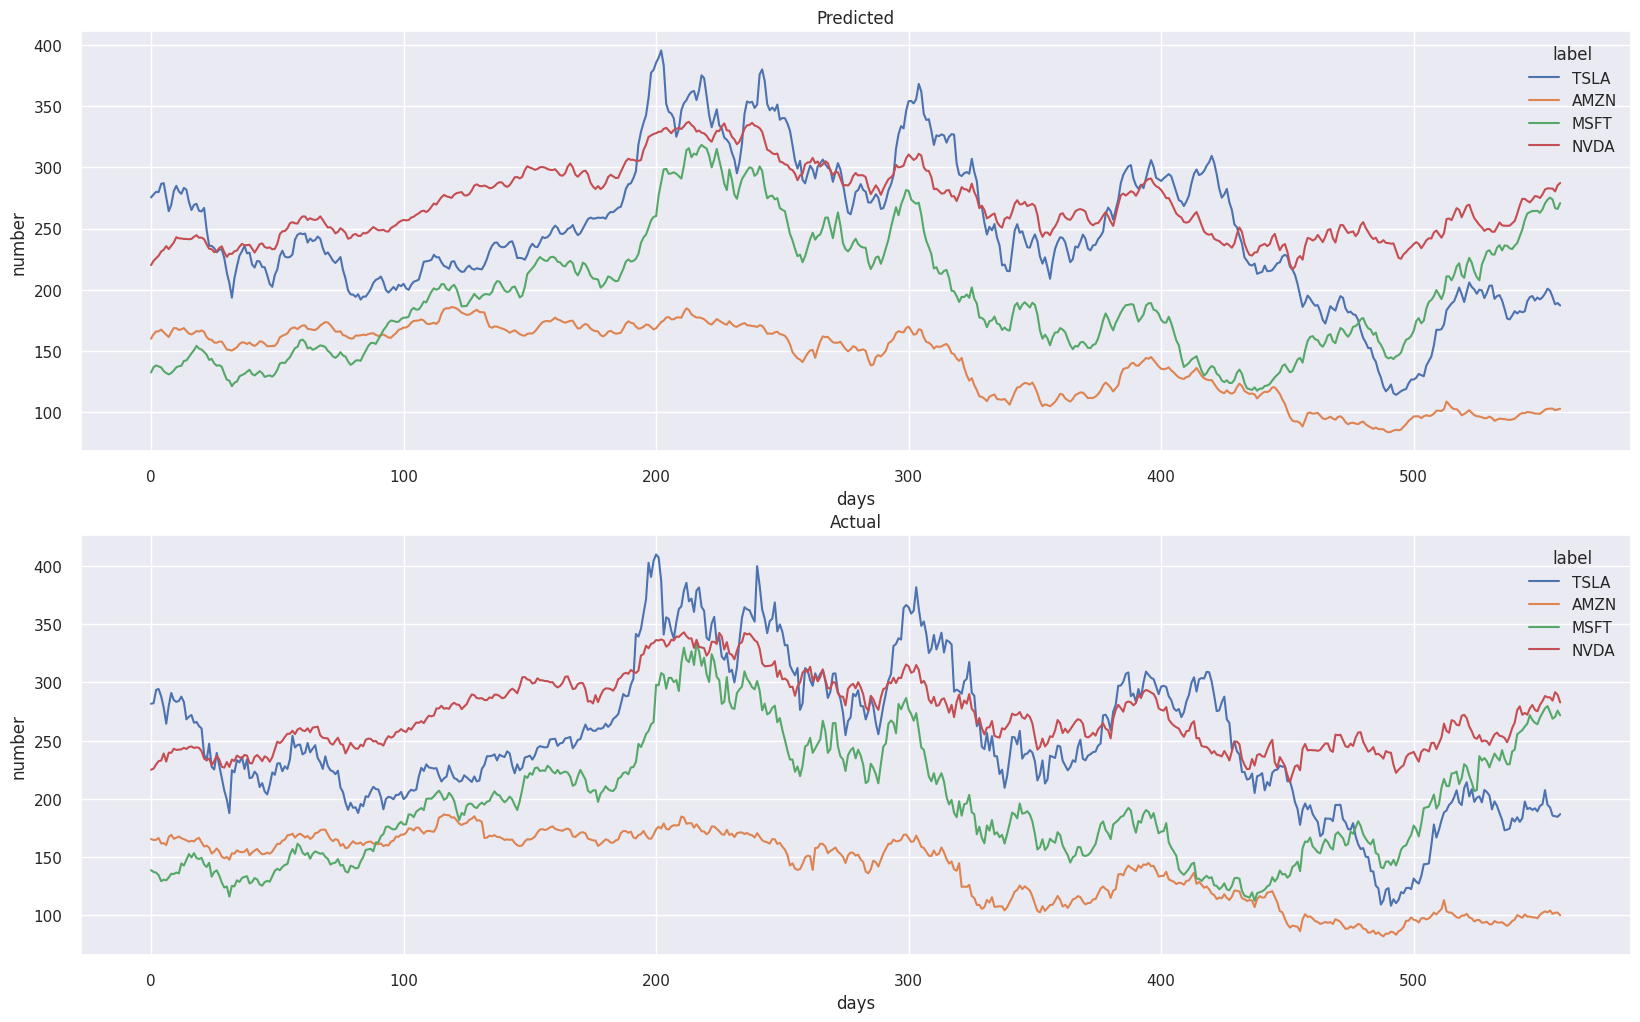

In [ ]:
fig = plt.figure(figsize = (20, 12))
ax1 = fig.add_subplot(211)
sns.set_theme()

ax1.set_title('Predicted')
sns.lineplot(rt_2, y = 'number', x = 'days', hue = 'label')#, hue = ['label']

ax2 = fig.add_subplot(212)
ax2.set_title('Actual')
sns.lineplot(rt2_2, y = 'number', x = 'days', hue = 'label')
plt.plot()

In [ ]:
# pred2 = pd.DataFrame(yhat.T[0])
retPred_test = fn.calculateReturns(rt.copy(), 1).fillna(0)
# retPred_test = pred2.to_numpy().reshape(int(pred2.shape[0]/4), 4)
retPred_test = pd.DataFrame(retPred_test)
retPred_test

,TSLA,AMZN,MSFT,NVDA
0,0.000000,0.000000,0.000000,0.000000
1,0.008661,0.023035,0.032127,0.015966
2,0.007739,0.013544,0.010515,0.009051
3,-0.000952,0.000904,-0.005683,0.009434
4,0.023995,0.008127,-0.005989,0.014803
...,...,...,...,...
554,-0.007837,0.001211,0.006075,-0.000577
555,-0.026728,0.000648,-0.005598,-0.000190
556,-0.030164,-0.012758,-0.025417,-0.008263
557,0.005388,0.005374,-0.002794,0.017947


In [ ]:
retPred_test2 = fn.calculateReturns(Ret1test.copy(), 1).fillna(0)
retPred_test2 = retPred_test2.iloc[30:].reset_index(drop = True)
retPred_test2.loc[0, :] = 0
retPred_test2

,TSLA,AMZN,MSFT,NVDA
0,0.000000,0.000000,0.000000,0.000000
1,0.001953,-0.004463,-0.011177,0.004356
2,0.040348,0.000538,-0.004321,0.015844
3,0.002600,0.009754,-0.015967,0.012199
4,-0.021436,-0.028126,-0.038518,0.002453
...,...,...,...,...
554,-0.011244,0.015038,-0.018309,-0.000174
555,-0.036660,-0.027417,-0.020836,-0.009889
556,-0.002480,0.009496,0.005803,0.025533
557,-0.002972,0.001078,0.020047,-0.007579


In [ ]:
longs = pd.DataFrame((retPred_test>0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame((retPred_test<0).astype(int)).shift(1)
longs.loc[0] = 0
shorts.loc[0] = 0

# retPred_test.shape, longs.shape, shorts.shape

positions = np.zeros(retPred_test.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.astype(bool).values
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.astype(bool).values
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).values.squeeze(), 
                           retPred_test.fillna(0).values), axis = 1)
               

dPos = np.sum(pd.DataFrame(positions).shift(1).abs().values.squeeze(), axis = 1)

# dRetA.shape, dPos.shape

dailyRet = np.divide(dRetA, dPos)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

dailyRet.shape, cumret.shape

((559,), (559,))

In [ ]:
longs2 = pd.DataFrame((retPred_test2>0).astype(int)).shift(1) #1 day later
shorts2 = pd.DataFrame((retPred_test2<0).astype(int)).shift(1)
longs2.loc[0] = 0
shorts2.loc[0] = 0

# retPred_test.shape, longs.shape, shorts.shape

positions2 = np.zeros(retPred_test2.shape)

for h in range(holdingDays):
    long_lag2 = longs2.shift(h)
    long_lag2.fillna(value=0, inplace=True)
    long_lag2 = long_lag2.astype(bool).values
    
    short_lag2 = shorts2.shift(h)
    short_lag2.fillna(value=0, inplace=True)
    short_lag2 = short_lag2.astype(bool).values
    
    positions2[long_lag2] += 1
    positions2[short_lag2] -= 1

dRetA2 = np.sum(np.multiply(pd.DataFrame(positions2).shift(1).fillna(0).values.squeeze(), 
                           retPred_test2.fillna(0).values), axis = 1)
               

dPos2 = np.sum(pd.DataFrame(positions2).shift(1).abs().values.squeeze(), axis = 1)

# dRetA.shape, dPos.shape

dailyRet2 = np.divide(dRetA2, dPos2)
dailyRet2[~np.isfinite(dailyRet2)] = 0
cumret2 = np.cumprod(1 + dailyRet2) - 1

dailyRet2.shape, cumret2.shape

((559,), (559,))

Out-of-sample: CAGR=0.0903176 Sharpe ratio=0.502926 maxDD=-0.434062 maxDDD=356 Calmar ratio=0.208075


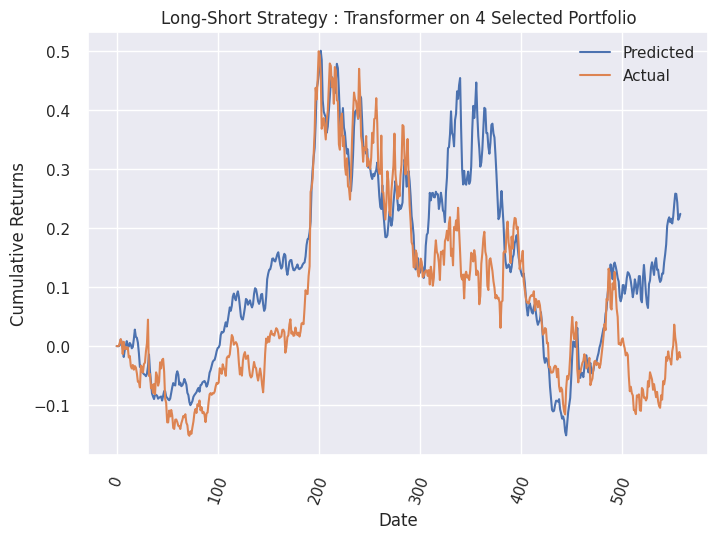

In [ ]:
plt.figure(2)
plt.xticks(rotation=70)
plt.plot(retPred_test.index, cumret, label = 'Predicted')
plt.plot(retPred_test2.index, cumret2, label = 'Actual')
plt.title('Long-Short Strategy : Transformer on 4 Selected Portfolio')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show()

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
#seaborn.mpl.rcParams['savefig.dpi'] = 90
'''
https://people.duke.edu/~ccc14/sta-663/ResamplingAndMonteCarloSimulations.html
This subroutine will calculate White's Reality Check for a single trading rule
in accordance with Aronson's Evidence Based Technical Analysis p.237ff

'''


#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)


    
    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
   # plt.show()
    

    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.


average return 0.132739
[-0.01271487  0.01337233]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


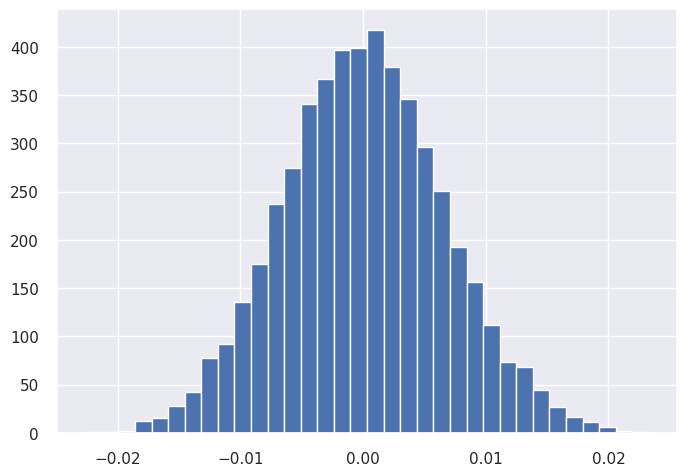

In [ ]:
bootstrap(pd.Series(cumret))
plt.show()

# **Equity Curve Calculation**

In [ ]:
retPred_Test = retPred_test.copy()
retPred_Test2 = retPred_test2.copy()

for i in retPred_Test.columns :
    retPred_Test[i] = np.cumprod(1 + retPred_Test[i]) - 1
for i in retPred_Test2.columns :
    retPred_Test2[i] = np.cumprod(1 + retPred_Test2[i]) - 1



retPred_Test['days'] = retPred_Test.index
retPred_test_ec = retPred_Test.melt('days', var_name='label', value_name='number')
retPred_Test = retPred_Test.drop(['days'], axis = 1)

retPred_Test2['days'] = retPred_Test2.index
retPred_test2_ec = retPred_Test2.melt('days', var_name='label', value_name='number')
retPred_Test2 = retPred_Test2.drop(['days'], axis = 1)


[]

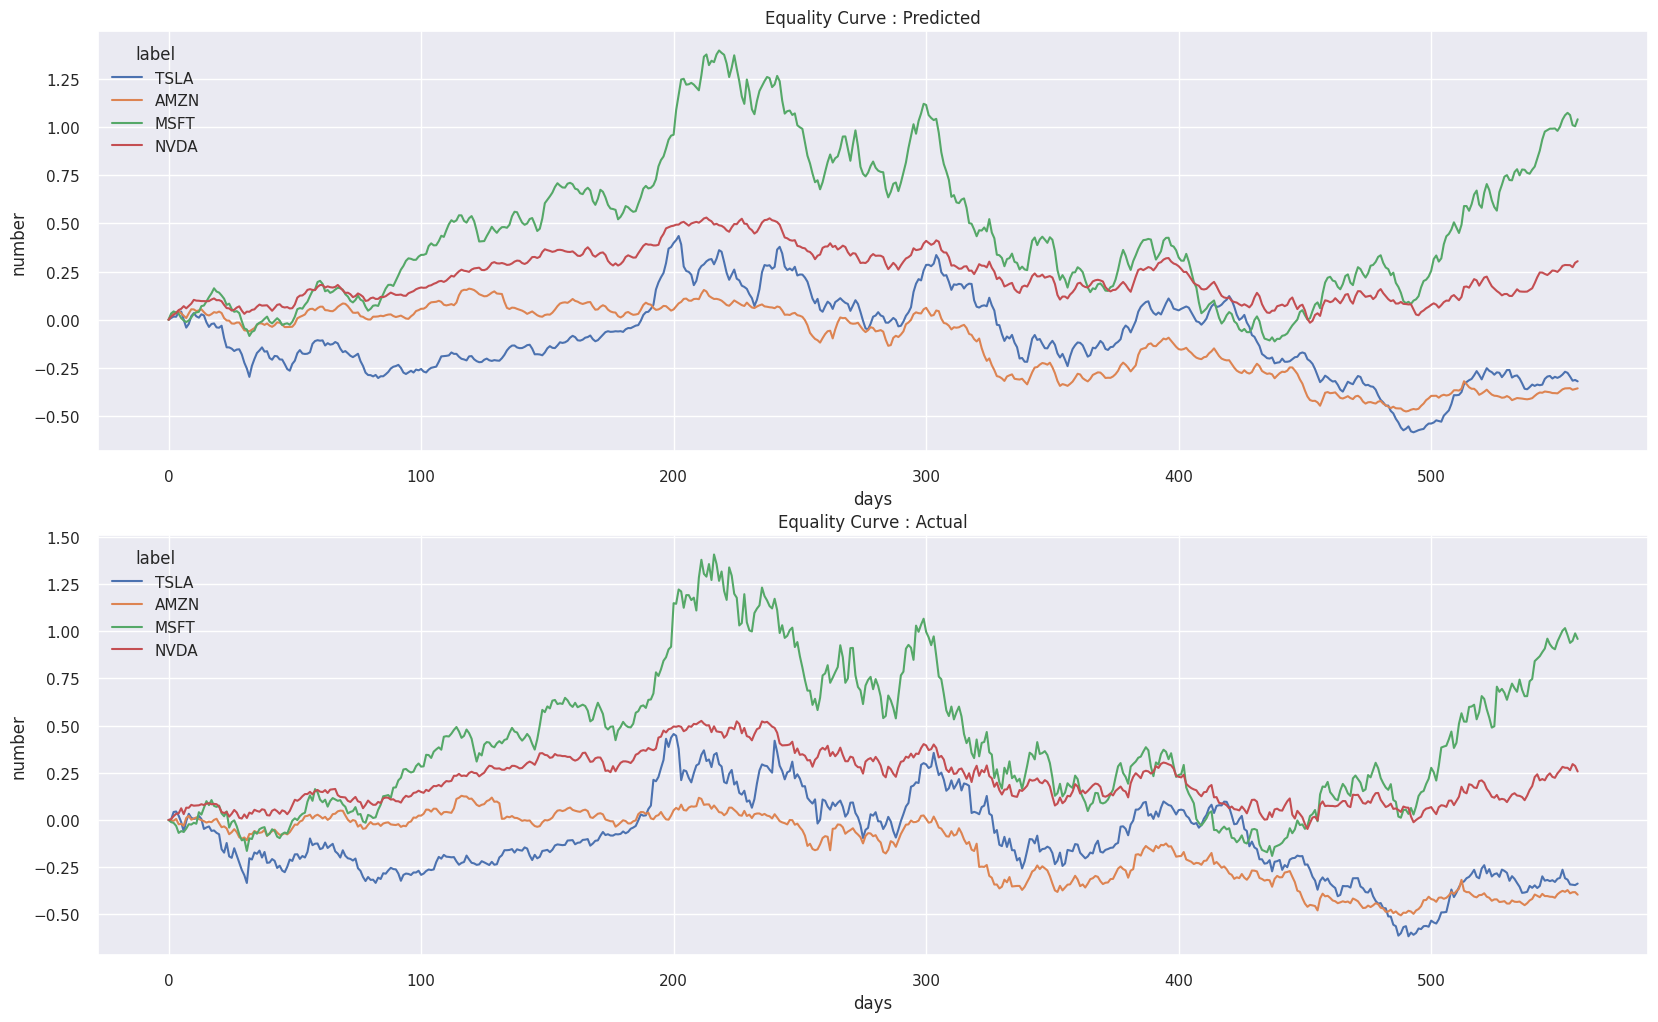

In [ ]:
fig = plt.figure(figsize = (20, 12))
ax1 = fig.add_subplot(211)
sns.set_theme()

ax1.set_title('Equality Curve : Predicted')
sns.lineplot(retPred_test_ec, y = 'number', x = 'days', hue = 'label')#, hue = ['label']

ax2 = fig.add_subplot(212)
ax2.set_title('Equality Curve : Actual')
sns.lineplot(retPred_test2_ec, y = 'number', x = 'days', hue = 'label')
plt.plot()

In [ ]:
retPred_Test2['EC'] = (retPred_Test2.TSLA + retPred_Test2.AMZN + retPred_Test2.MSFT + retPred_Test2.NVDA) / 4
retPred_Test['EC'] = (retPred_Test.TSLA + retPred_Test.AMZN + retPred_Test.MSFT + retPred_Test.NVDA) / 4

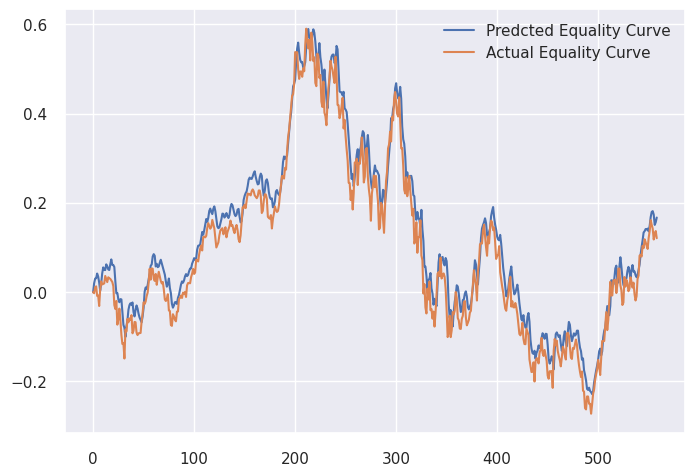

In [ ]:
sns.set_theme()
retPred_Test.EC.plot(label = 'Predcted Equality Curve')
retPred_Test2.EC.plot(label = 'Actual Equality Curve')
plt.legend()
plt.show()